In [56]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import os, dotenv
project_path = os.path.dirname(dotenv.find_dotenv())

import pickle

p=print

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
"""
Import Data.
"""

Ty=1
Tx=72

X_train=pd.read_csv('../data/processed/X_train_tx{}_ty{}.csv'.format(Tx, Ty))
Y_train=pd.read_csv('../data/processed/Y_train_tx{}_ty{}.csv'.format(Tx, Ty))
X_test=pd.read_csv('../data/processed/X_test_tx{}_ty{}.csv'.format(Tx, Ty))
Y_test=pd.read_csv('../data/processed/Y_test_tx{}_ty{}.csv'.format(Tx, Ty))

N_FEATURES=int(X_train.columns.values.size / Tx)

In [71]:
"""
Evaluate Dummy Models.
"""

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

for strategy in ['mean', 'median', 'constant']:
    
    if strategy=='constant':
        dummy=DummyRegressor(strategy=strategy, constant=(0,))
    else:
        dummy=DummyRegressor(strategy=strategy)
    dummy.fit(X_train, Y_train)
    dummy_predict = dummy.predict(X_test)
    print('{} Dummy MAE: {}'.format(strategy, mean_absolute_error(y_true=Y_test, y_pred=dummy_predict)))
    print('{} Dummy MSE: {}'.format(strategy, mean_squared_error(y_true=Y_test, y_pred=dummy_predict)))

mean Dummy MAE: 0.3896809058727269
mean Dummy MSE: 0.6393643977603765
median Dummy MAE: 0.38976166116763566
median Dummy MSE: 0.639276339680805
constant Dummy MAE: 0.3894161012557916
constant Dummy MSE: 0.6397215326190434


In [72]:
"""
Scale the data.
"""
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for X_data in [X_train_scaled, X_test_scaled]:
    p('Max: {}\nMin: {}\nMean: {}'.format(X_data.min(), X_data.max(), X_data.mean()))

Max: -8.586913717279383
Min: 13.369546402604646
Mean: 0.0
Max: -2.6045053521367856
Min: 5.501481159578786
Mean: -0.8616983396858965


In [73]:
"""
Reshape the model into a 3D array to fit the RNN Model.
"""
def shape_model_data(data, n_timesteps, n_features):
    model_data = data.reshape((data.shape[0], n_timesteps, n_features))
    return model_data
X_train_3D = shape_model_data(X_train_scaled, Tx, N_FEATURES)
X_test_3D = shape_model_data(X_test_scaled, Tx, N_FEATURES)

p(X_train_3D.shape)
p(X_test_3D.shape)

(5566, 72, 17)
(293, 72, 17)


In [74]:
from keras.layers import Input, LSTM, BatchNormalization, Dense
from keras import Model

from keras.initializers import RandomNormal, Ones, Constant

def lstm_model(input_shape, num_outputs, kernel_init='normal', bias_init='zeros'):
    
    model_input = Input(shape=input_shape, dtype='float32')
    #     initializer = RandomNormal(mean=1.0, stddev=0.05, seed=0)

    model_output = LSTM(units=64, return_sequences=True, kernel_initializer=kernel_init, bias_initializer=bias_init, activation='relu')(model_input)
    model_output = BatchNormalization(axis=-1)(model_output)
    model_output = LSTM(units=64, return_sequences=False, kernel_initializer=kernel_init, bias_initializer=bias_init, activation='relu')(model_output)
    model_output = BatchNormalization(axis=-1)(model_output)
    model_output = Dense(num_outputs, kernel_initializer=kernel_init, bias_initializer=bias_init, activation='linear')(model_output)

    model = Model(inputs=model_input, outputs=model_output)
    return model


In [75]:
model=lstm_model(X_train_3D.shape[1:], Ty)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 72, 17)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 72, 64)            20992     
_________________________________________________________________
batch_normalization_17 (Batc (None, 72, 64)            256       
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_18 (Batc (None, 64)                256       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 54,593
Trainable params: 54,337
Non-trainable params: 256
_________________________________________________________________


In [77]:
from keras.optimizers import Adam
"""
Set model training parameters.
"""
epochs = 5
batch_size = 32
learning_rate=.01
decay_rate = learning_rate / epochs

"""
Compile and fit model.
"""
model.compile(loss='mse', optimizer=Adam(lr=learning_rate, decay=decay_rate), metrics=['mae'])

fit = model.fit(X_train_3D, Y_train,
                shuffle=False,
                epochs=epochs, 
                batch_size=batch_size, 
                validation_data=(X_test_3D, Y_test)
               )

Train on 5566 samples, validate on 293 samples
Epoch 1/5
5566/5566 [==============================] - 24s 4ms/step - loss: 1.7400 - mean_absolute_error: 0.8523 - val_loss: 25.0243 - val_mean_absolute_error: 3.9296
Epoch 2/5
5566/5566 [==============================] - 21s 4ms/step - loss: 1.7257 - mean_absolute_error: 0.8459 - val_loss: 2.9336 - val_mean_absolute_error: 0.8877
Epoch 3/5
5566/5566 [==============================] - 25s 4ms/step - loss: 1.7253 - mean_absolute_error: 0.8450 - val_loss: 5.1009 - val_mean_absolute_error: 1.2115
Epoch 4/5
5566/5566 [==============================] - 23s 4ms/step - loss: 1.7227 - mean_absolute_error: 0.8444 - val_loss: 1.0216 - val_mean_absolute_error: 0.5416
Epoch 5/5
5566/5566 [==============================] - 22s 4ms/step - loss: 1.7208 - mean_absolute_error: 0.8439 - val_loss: 0.6450 - val_mean_absolute_error: 0.3911


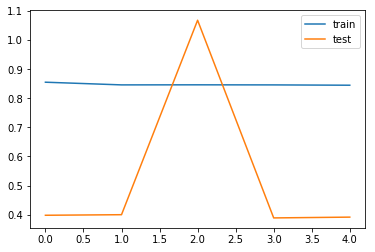

In [64]:
"""
Check out loss from train and dev sets
"""
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='test')
plt.legend()

In [65]:
prediction = model.predict(X_test_3D)
backtest=model.predict(X_train_3D)

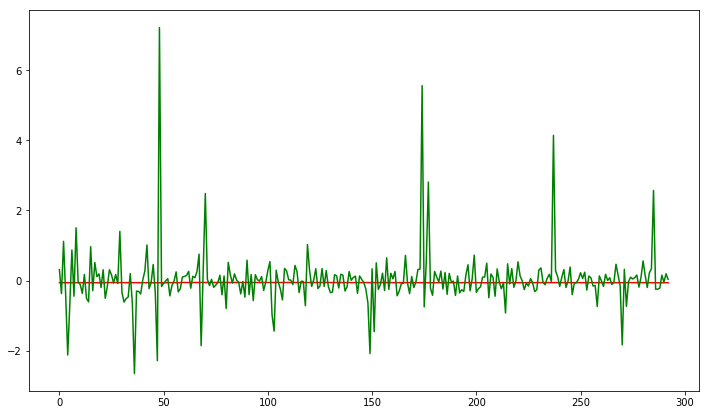

In [66]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(12,7))
plt.plot(prediction, 'r')
plt.plot(Y_test.values, 'g')

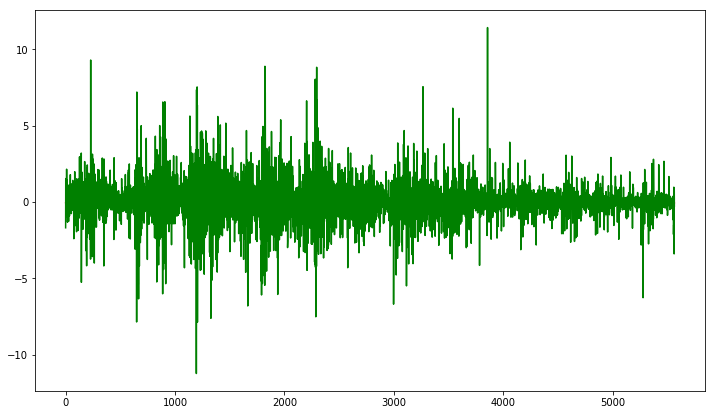

In [67]:
fig,ax=plt.subplots(figsize=(12,7))
plt.plot(backtest, 'r')
plt.plot(Y_train.values, 'g')